# IGA Upsample Mapping for 2D cases

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import h5py
import scipy.sparse as sp

#### 1. Define the Reference Square and Target Quadrilateral
   
   This will involve specifying the points of the unit square and their parametric coordinates.
   
   Input the coordinates of the quadrilateral to which you will map the unit square.

In [3]:
# Define the reference square and the target quadrilateral vertices
ref_square = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])
quad_vertices = np.array([[1, 1], [3, 2], [2, 4], [0, 3]])  # Example vertices

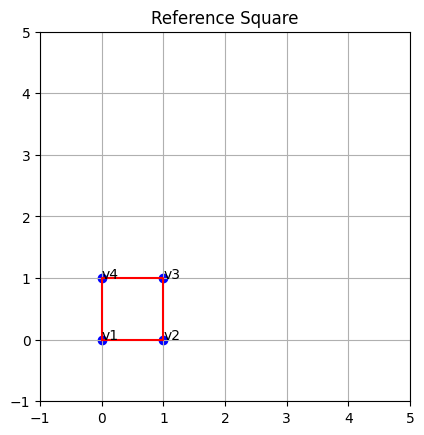

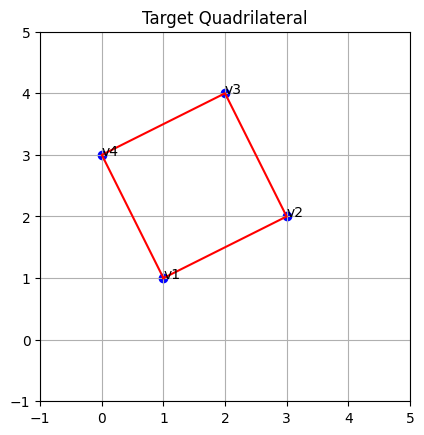

In [4]:

# Function to plot quadrilaterals
def plot_quad(vertices, title='Quadrilateral'):
    fig, ax = plt.subplots()
    quad = np.vstack([vertices, vertices[0]])  # Close the loop
    ax.plot(quad[:, 0], quad[:, 1], 'r-')
    ax.set_xlim([-1, 5])
    ax.set_ylim([-1, 5])
    ax.set_aspect('equal')
    ax.scatter(vertices[:, 0], vertices[:, 1], color='blue')
    for i, txt in enumerate(['v1', 'v2', 'v3', 'v4']):
        ax.annotate(txt, (vertices[i, 0], vertices[i, 1]))
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_quad(ref_square, 'Reference Square')
plot_quad(quad_vertices, 'Target Quadrilateral')

#### 3. Define the Quadratic B-spline Basis Functions

In [7]:
# def B_spline_basis(t, degree, i, knots):
#     """Recursive definition of B-spline basis function of given degree."""
#     if degree == 0:
#         return 1.0 if knots[i] <= t < knots[i+1] else 0.0
#     else:
#         coef1 = (t - knots[i]) / (knots[i+degree] - knots[i]) if knots[i+degree] != knots[i] else 0
#         coef2 = (knots[i+degree+1] - t) / (knots[i+degree+1] - knots[i+1]) if knots[i+degree+1] != knots[i+1] else 0
#         return coef1 * B_spline_basis(t, degree-1, i, knots) + coef2 * B_spline_basis(t, degree-1, i+1, knots)

# def tensor_product_basis_2D(x, y, degree, knots):
#     """Compute the tensor product of 1D B-spline basis functions for 2D."""
#     basis_x = B_spline_basis(x, degree, 1, knots)
#     basis_y = B_spline_basis(y, degree, 1, knots)
#     return basis_x * basis_y

# # Define knots for linear and quadratic B-splines for a unit square
# degree = 2  # Change to 1 for linear basis
# knots = [0, 0, 0, 1, 1, 1]  # Clamped knots for quadratic B-splines

In [5]:
# Define linear B-spline basis functions
def L_0(u): return 1 - u
def L_1(u): return u

def tensor_product_linear_b_spline(u, v):
    """ Compute the tensor product of 1D linear B-spline basis functions for 2D space. """
    basis_functions_1d_u = [L_0(u), L_1(u)]
    basis_functions_1d_v = [L_0(v), L_1(v)]
    
    basis_functions_2d = {}
    for I, fu in enumerate(basis_functions_1d_u):
        for J, fv in enumerate(basis_functions_1d_v):
            basis_functions_2d[(I, J)] = fu * fv  # Multiplying basis functions in u and v direction

    return basis_functions_2d

In [7]:
print(tensor_product_linear_b_spline(0.5, 0.5))

{(0, 0): 0.25, (0, 1): 0.25, (1, 0): 0.25, (1, 1): 0.25}


In [6]:
# Define quadratic B-spline basis functions
def B_0(u): return (1-u)**2
def B_1(u): return 2*u*(1-u)
def B_2(u): return u**2

def tensor_product_b_spline(u, v):
    """ Compute the tensor product of 1D B-spline basis functions for 2D space. """
    basis_functions_1d_u = [B_0(u), B_1(u), B_2(u)]
    basis_functions_1d_v = [B_0(v), B_1(v), B_2(v)]
    
    basis_functions_2d = {}
    for i, fu in enumerate(basis_functions_1d_u):
        for j, fv in enumerate(basis_functions_1d_v):
            basis_functions_2d[(i, j)] = fu * fv  # Multiplying basis functions in u and v direction

    return basis_functions_2d

In [5]:
# # Example usage of basis functions
# u = 0.5
# print("B_0 at 0.5:", B_0(u))
# print("B_1 at 0.5:", B_1(u))
# print("B_2 at 0.5:", B_2(u))

In [7]:
# # Abandoned!
# Bilinear interpolation for transformation
def bilinear_interp(xi, eta, vertices):
    x = (1-xi)*(1-eta)*vertices[0][0] + xi*(1-eta)*vertices[1][0] + xi*eta*vertices[2][0] + (1-xi)*eta*vertices[3][0]
    y = (1-xi)*(1-eta)*vertices[0][1] + xi*(1-eta)*vertices[1][1] + xi*eta*vertices[2][1] + (1-xi)*eta*vertices[3][1]
    return np.array([x, y])

#### 4. Upsample the Reference Square

In [11]:
# Generate a grid of points in the reference square (upsampling)
num_points_per_side = 2  # Number of points per side
xi = np.linspace(0, 1, num_points_per_side)
eta = np.linspace(0, 1, num_points_per_side)

xi_grid, eta_grid = np.meshgrid(xi, eta)
xi_flat = xi_grid.flatten()
eta_flat = eta_grid.flatten()

vertices = np.column_stack((xi_flat, eta_flat)) # Upsampled vertices on the reference shape
transformed_points = np.array([bilinear_interp(x, y, quad_vertices) for x, y in zip(xi_flat, eta_flat)]) # Upsampled vertices on the target shape

print(xi_flat)

[0. 1. 0. 1.]


In [10]:
# Define the triangles and edges for a structured grid
faces = []
edges = set()  # To avoid duplicates

for i in range(num_points_per_side - 1):
    for j in range(num_points_per_side - 1):
        bottom_left = i * num_points_per_side + j
        bottom_right = bottom_left + 1
        top_left = bottom_left + num_points_per_side
        top_right = top_left + 1
        
        # Define two triangles for each square
        faces.append([bottom_left, top_left, top_right])
        faces.append([bottom_left, top_right, bottom_right])
        
        # Add edges, ensure each edge is added once
        edges.update([
            (bottom_left, top_left), (top_left, top_right), (top_right, bottom_left),
            (bottom_left, bottom_right), (bottom_right, top_right), (top_right, bottom_left)
        ])

# Convert edges set to sorted list
ordered_edges = np.array(list(edges), dtype=np.int64)
ordered_faces = np.array(faces, dtype=np.int64)

In [11]:
# Save the upsampled target mesh
def save_mesh_as_obj(vertices, faces, filename='mesh.obj'):
    """
    Save a 2D mesh as an OBJ file.
    
    Parameters:
    - vertices: NumPy array of shape (n, 2) for vertex coordinates.
    - faces: NumPy array of shape (m, 3) for indices of vertices forming each triangle.
    - filename: String, the path where the .obj file will be saved.
    """
    with open(filename, 'w') as file:
        # Write vertices
        for vertex in vertices:
            file.write(f"v {vertex[0]} {vertex[1]} 0.0\n")
        
        # Write faces
        for face in faces:
            # OBJ files are 1-indexed
            file.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")

    print(f"Mesh saved to {filename}")

filename = '2d-quad-upsample.obj'
save_mesh_as_obj(transformed_points, faces, filename)

Mesh saved to 2d-quad-upsample.obj


In [12]:
# Save the original target mesh
def save_quadrilateral_as_obj(vertices, filename='quadrilateral.obj'):
    """
    Save a set of vertices that define a quadrilateral into an OBJ file.

    Parameters:
    - vertices: NumPy array of shape (4, 2) for vertex coordinates of the quadrilateral.
    - filename: String, the path where the .obj file will be saved.
    """
    with open(filename, 'w') as file:
        # Write vertices
        for vertex in vertices:
            # Assume z = 0 since vertices are 2D
            file.write(f"v {vertex[0]} {vertex[1]} 0.0\n")
        
        # Write face
        # OBJ file indices start at 1 and since it's a quadrilateral, we connect four vertices
        file.write("f 1 2 3 4\n")

    print(f"Quadrilateral saved to {filename}")

ori_filename = '2d-quad.obj'
save_quadrilateral_as_obj(quad_vertices, ori_filename)

Quadrilateral saved to 2d-quad.obj


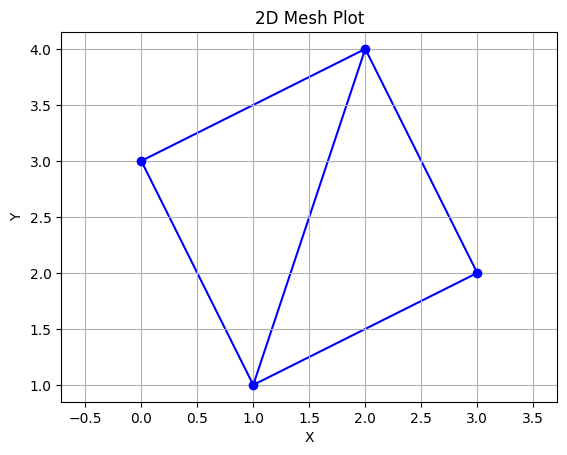

In [13]:
# Plot the upsampled target mesh
def plot_mesh(vertices, faces):
    """
    Plot a 2D mesh using matplotlib.
    
    Parameters:
    - vertices: NumPy array of shape (n, 2) for vertex coordinates.
    - faces: NumPy array of shape (m, 3) for indices of vertices forming each triangle.
    """
    fig, ax = plt.subplots()
    tri = mtri.Triangulation(vertices[:, 0], vertices[:, 1], faces)
    ax.triplot(tri, 'bo-')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('2D Mesh Plot')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

plot_mesh(transformed_points, faces)

#### 5. Map Points from Reference to Quadrilateral

Abandoned!

Use bilinear interpolation to map points from the reference square to the target quadrilateral based on the control points.

In [12]:
# Transform each point in the grid to the quadrilateral
transformed_points = np.array([bilinear_interp(x, y, quad_vertices) for x, y in zip(xi_flat, eta_flat)])

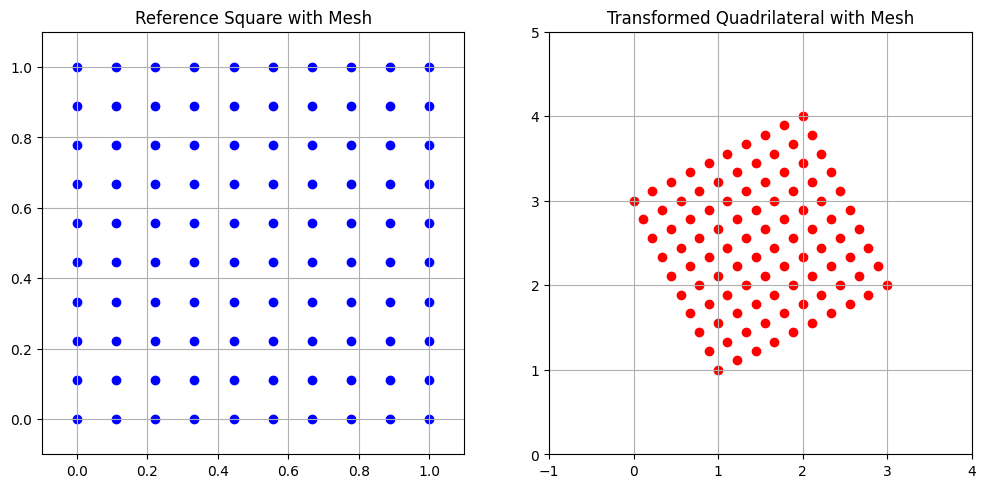

In [13]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot reference square with mesh
axs[0].scatter(xi_flat, eta_flat, color='blue')
axs[0].set_title('Reference Square with Mesh')
axs[0].set_xlim([-0.1, 1.1])
axs[0].set_ylim([-0.1, 1.1])
axs[0].set_aspect('equal')
axs[0].grid(True)

# Plot transformed quadrilateral with mesh
axs[1].scatter(transformed_points[:, 0], transformed_points[:, 1], color='red')
axs[1].set_title('Transformed Quadrilateral with Mesh')
axs[1].set_xlim([min(transformed_points[:, 0])-1, max(transformed_points[:, 0])+1])
axs[1].set_ylim([min(transformed_points[:, 1])-1, max(transformed_points[:, 1])+1])
axs[1].set_aspect('equal')
axs[1].grid(True)

plt.show()

#### 6. Construct W matrix

In [62]:
# # Abandoned!
# # Bilinear interpolation function to calculate weights
# def bilinear_weights(xi, eta):
#     return np.array([
#         (1 - xi) * (1 - eta),   # Weight for v1
#         xi * (1 - eta),         # Weight for v2
#         xi * eta,               # Weight for v3
#         (1 - xi) * eta          # Weight for v4
#     ])

# # Compute weights for each point in the mesh
# W = np.array([bilinear_weights(x, y) for x, y in zip(xi_flat, eta_flat)])

# print(W.shape)

# # Abandonded!
# # Visualize the transformation by plotting the reference and target quadrilaterals with mesh points
# transformed_points = np.dot(W, quad_vertices)  # Transform points by weights

# fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# # Plot reference square with mesh
# axs[0].scatter(xi_flat, eta_flat, color='blue')
# axs[0].set_title('Reference Square with Mesh')
# axs[0].set_xlim([-0.1, 1.1])
# axs[0].set_ylim([-0.1, 1.1])
# axs[0].set_aspect('equal')
# axs[0].grid(True)

# # Plot transformed quadrilateral with mesh
# axs[1].scatter(transformed_points[:, 0], transformed_points[:, 1], color='red')
# axs[1].set_title('Transformed Quadrilateral with Mesh')
# axs[1].set_xlim([min(transformed_points[:, 0])-1, max(transformed_points[:, 0])+1])
# axs[1].set_ylim([min(transformed_points[:, 1])-1, max(transformed_points[:, 1])+1])
# axs[1].set_aspect('equal')
# axs[1].grid(True)

# plt.show()

(100, 4)


In [15]:
# Define linear B-spline basis functions
def L_0(u): return 1 - u
def L_1(u): return u

def tensor_product_linear_b_spline(u, v):
    """ Compute the tensor product of 1D linear B-spline basis functions for 2D space. """
    basis_functions_1d_u = [L_0(u), L_1(u)]
    basis_functions_1d_v = [L_0(v), L_1(v)]
    
    basis_function_values = np.zeros((2, 2))
    for i, fu in enumerate(basis_functions_1d_u):
        for j, fv in enumerate(basis_functions_1d_v):
            basis_function_values[i, j] = fu * fv
    
    return basis_function_values.flatten()

# Now compute weights for each point in the mesh using the new basis function weights
W = np.array([tensor_product_linear_b_spline(x, y) for x, y in zip(xi_flat, eta_flat)])

print(W.shape)

(4, 4)


In [16]:
print(tensor_product_linear_b_spline(0.5, 0.5))

[0.25 0.25 0.25 0.25]


In [11]:
### Should use this!!!!!!
def tensor_product_b_spline_weights(u, v):
    """ Compute the tensor product of 1D B-spline basis functions for 2D space. """
    basis_functions_1d_u = [B_0(u), B_1(u), B_2(u)]
    basis_functions_1d_v = [B_0(v), B_1(v), B_2(v)]
    
    weights = np.zeros((3, 3))  # Assuming a 3x3 control point grid for quadratic B-splines
    for i in range(3):
        for j in range(3):
            weights[i, j] = basis_functions_1d_u[i] * basis_functions_1d_v[j]

    return weights.flatten()

# Now compute weights for each point in the mesh using the new basis function weights
W = np.array([tensor_product_b_spline_weights(x, y) for x, y in zip(xi_flat, eta_flat)])

print(W.shape)

(4, 9)


In [19]:
# Print aprt of the weights matrix W for verification
print("Matrix W (first few rows):")
print(W[:5])

Matrix W (first few rows):
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


In [20]:
# Save the weights matrix W in a sparse format as .hdf5

# Convert W to a sparse matrix in COO format
W_sparse = sp.coo_matrix(W)

# Extract non-zero entries for saving in sparse format
rows = W_sparse.row
cols = W_sparse.col
values = W_sparse.data

map_filename = '2d-quad-map.hdf5'

# Save to HDF5
with h5py.File(map_filename, 'w') as f:
    # Save edges and faces with explicit data types
    f.create_dataset('ordered_edges', data=ordered_edges, dtype=np.int64)
    f.create_dataset('ordered_faces', data=ordered_faces, dtype=np.int64)
    
    # Save the weight triplets
    weight_group = f.create_group('weight_triplets')
    weight_group.attrs['shape'] = np.array(W_sparse.shape)  # Store the shape of the original matrix W
    weight_group.create_dataset('cols', data=W_sparse.col, dtype=np.int32)  # Column indices from COO
    weight_group.create_dataset('rows', data=W_sparse.row, dtype=np.int32)  # Row indices from COO
    weight_group.create_dataset('values', data=W_sparse.data, dtype=np.float64)  # Non-zero values from COO

print(f"Data saved successfully in {map_filename}")

Data saved successfully in 2d-quad-map.hdf5


In [21]:
# Create full indices for every element in W
rows, cols = np.indices(W.shape)
values = W.flatten()  # Flatten the matrix values to a 1D array

# Convert indices to 1D arrays for storage
rows = rows.flatten()
cols = cols.flatten()

with h5py.File(map_filename, 'w') as f:
    # Save edges and faces with explicit data types
    f.create_dataset('ordered_edges', data=ordered_edges, dtype=np.int64)
    f.create_dataset('ordered_faces', data=ordered_faces, dtype=np.int64)
    
    # Save the weights in the format similar to sparse matrix storage
    weight_group = f.create_group('weight_triplets')
    weight_group.attrs['shape'] = np.array(W.shape)  # Store the shape of the original matrix W
    weight_group.create_dataset('cols', data=cols.astype(np.int32))  # Column indices from W
    weight_group.create_dataset('rows', data=rows.astype(np.int32))  # Row indices from W
    weight_group.create_dataset('values', data=values, dtype=np.float64)  # Values from W

print(f"Data saved successfully in {map_filename}")

Data saved successfully in 2d-quad-map.hdf5


## Try 2

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def tensor_product_basis(x, y, z, degree, knots):
    """Compute the tensor product of 1D B-spline basis functions."""
    basis_x = B_spline_basis(x, degree, 0, knots)
    basis_y = B_spline_basis(y, degree, 0, knots)
    basis_z = B_spline_basis(z, degree, 0, knots)
    return basis_x * basis_y * basis_z

# Define knots and degree for quadratic B-splines
degree = 2
knots = [0, 0, 0, 1, 1, 1]  # Clamped knots for quadratic B-splines

# Sample points on S (top face of the cube)
points_on_S = np.array([[x, y, 1.0] for x in np.linspace(0, 1, 3) for y in np.linspace(0, 1, 3)])

# Assume 27 quadratic basis functions in 3D (3x3x3 control points)
number_of_basis_functions_in_M = 27
W = np.zeros((len(points_on_S), number_of_basis_functions_in_M))

# Evaluate the basis function at each point on S
for j, point in enumerate(points_on_S):
    print(point)
    for i in range(number_of_basis_functions_in_M):
        # We need to map the basis function index to its parametric coordinates
        # Here, just an example: simulate the indices mapping if needed
        ix, iy, iz = np.unravel_index(i, (3, 3, 3))  # Assuming a simple cubic layout of control points
        W[j, i] = tensor_product_basis(point[0], point[1], point[2], degree, knots)

print(W)

[0. 0. 1.]
[0.  0.5 1. ]
[0. 1. 1.]
[0.5 0.  1. ]
[0.5 0.5 1. ]
[0.5 1.  1. ]
[1. 0. 1.]
[1.  0.5 1. ]
[1. 1. 1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]]
